# Bike Safety in the Windy City - An analysis of severe bike crash contributors for Vision Zero Chicago

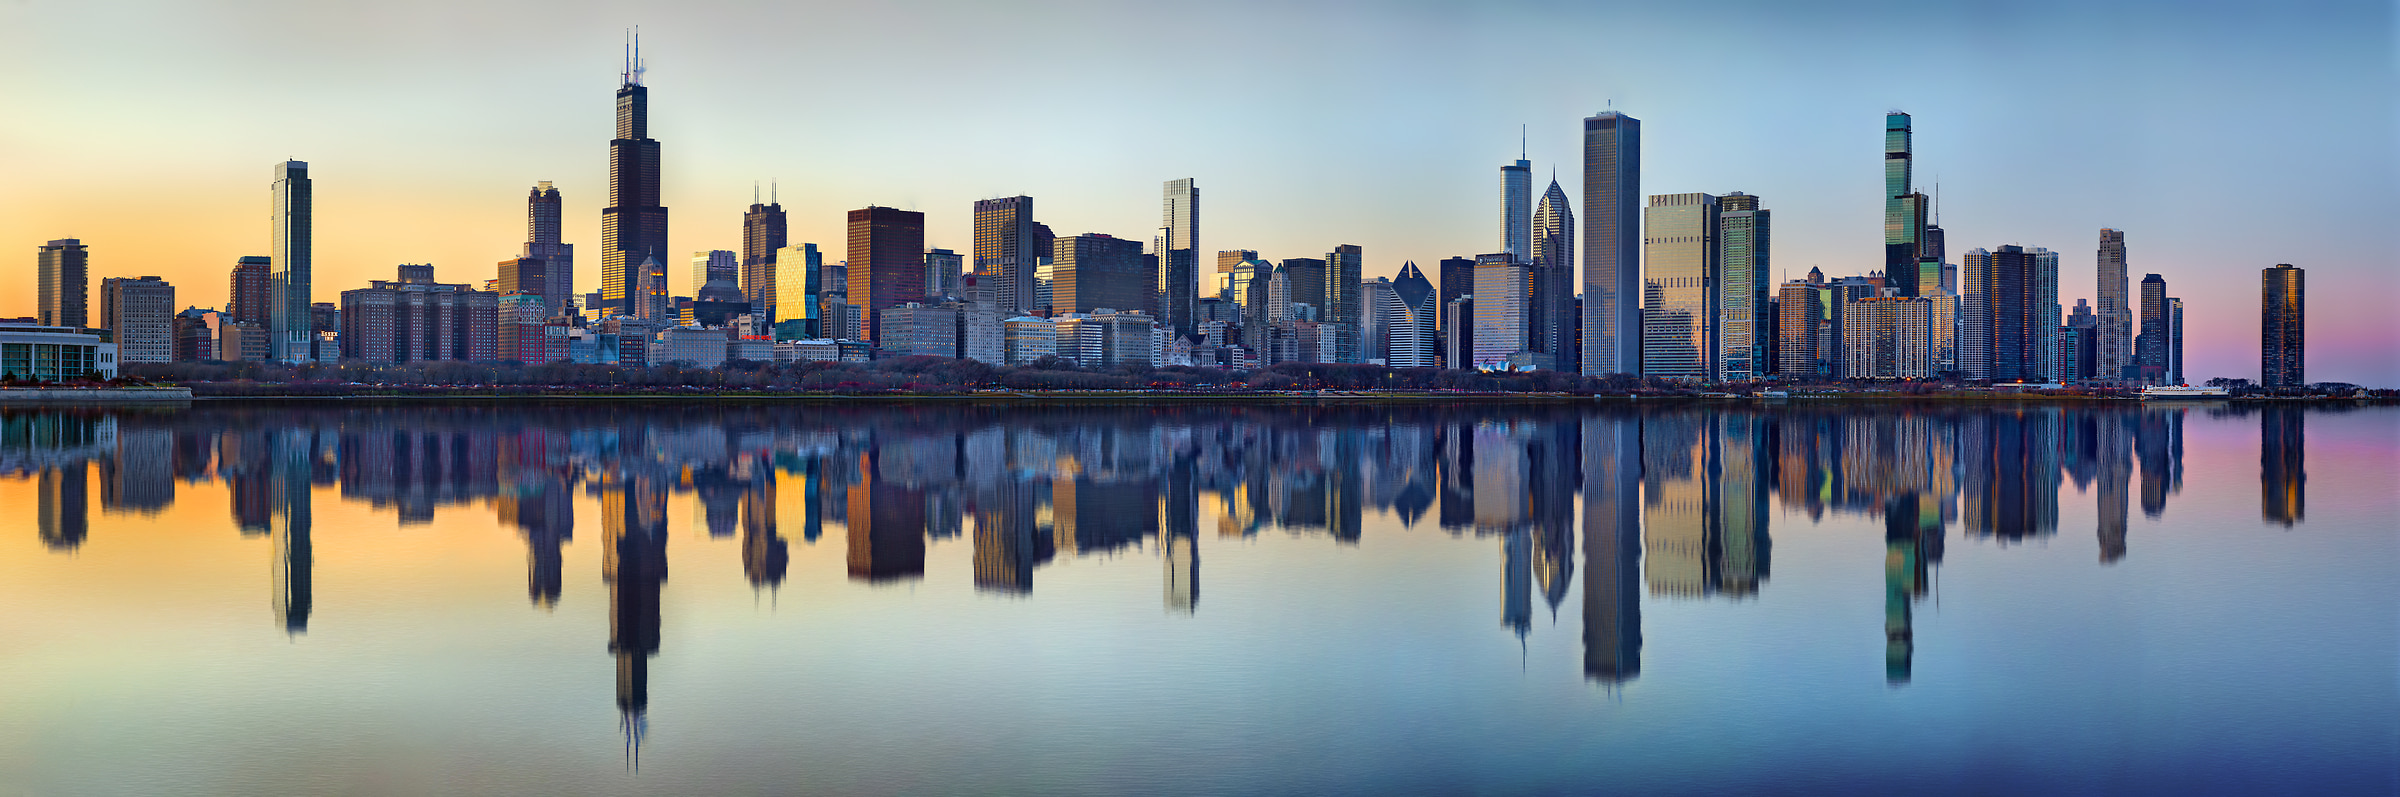

#### by Sean Conlon, Ryan Moore, and John Nahra

# Overview

We used data from the City of Chicago on car accidents involving cyclists to try to better understand the causes of incapacitating/fatal biker injuries. We ran several machine learning models, utilizing data on driver characteristics, biker characteristics, and crash conditions. In our results, we focused on feature importance and recall.

Our analysis has revealed that in order to improve bike safety in urban areas, we need to target policy/awareness for impaired drivers, older riders, biker rule following, time of day, and speed limits. These factors have a significant impact on the severity of cycling accidents.


# Business Understanding

Vision Zero Chicago (VZC) is the commitment and approach to eliminating fatalities and serious injuries from traffic crashes.

Vision Zero brings together the policies, partnerships, and technologies that prevent death and serious injury from traffic crashes. Traffic crashes are not “accidents.” We acknowledge that traffic deaths are preventable and unacceptable and commit to using all available tools to influence the conditions and behaviors that lead to serious crashes.

The engagement team has been hired to help with Vision Zero Chicago's mission by performing an analysis on bike-related accidents to determine circumstances that contribute to severe and fatal bike crashes.

# Data Understanding

The data we used is from the Chicago Data Portal, which shows information about each traffic crash on city streets within the City of Chicago limits and under the jurisdiction of Chicago Police Department (CPD).

We utilized two sets of information:

* Crashes - details out individual crashes and their characteristics
* People - details out each person involved in the crash and their characteristics

We started with the people dataset, filtered for bike-related crashes, then combined the crash dataset with the biker person dataset for a complete picture of each individual crash related to bicycles.

# Data Preparation

We had to use our best judgement with binning our data into appropriate categories. We also ran into some data limitations. 

First, the dataset had many unknown and missing values, which required dropping data points. Second, our target variable was skewed, with 90% of biker accidents being non-severe, so we performed random undersampling in order to balance the data for modeling.

Our final dataset included all categorical variables and contained approximately 6500 bike accidents. 


In [1]:
### Importing packages for data analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)

In [2]:
### Importing CSV

df = pd.read_csv('bikers.csv', low_memory=False)

## Binning Categorical Variables

In [3]:
### Binning target category (INJURY_CLASSIFICATION)

df.loc[df['INJURY_CLASSIFICATION'] == 'INCAPACITATING INJURY', 'INJURY_BAD'] = 1
df.loc[df['INJURY_CLASSIFICATION'] == 'FATAL', 'INJURY_BAD'] = 1

df.loc[df['INJURY_CLASSIFICATION'] == 'REPORTED, NOT EVIDENT', 'INJURY_BAD'] = 0
df.loc[df['INJURY_CLASSIFICATION'] == 'NO INDICATION OF INJURY', 'INJURY_BAD'] = 0
df.loc[df['INJURY_CLASSIFICATION'] == 'NONINCAPACITATING INJURY', 'INJURY_BAD'] = 0

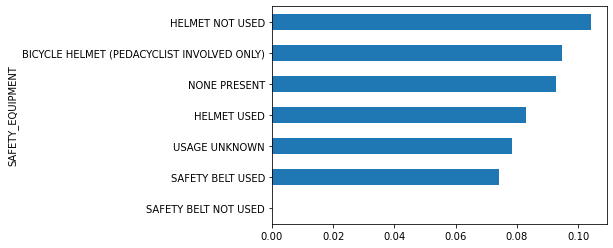

In [4]:
#checking severe injury rate by safety equipment category
df.groupby(by=['SAFETY_EQUIPMENT'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

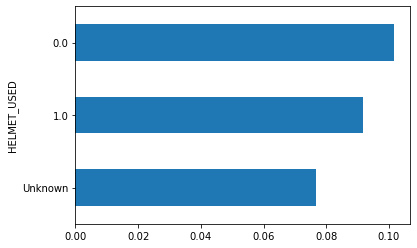

In [5]:
### Binning HELMET_USED feature:

df.loc[df['SAFETY_EQUIPMENT'] == 'HELMET USED', 'HELMET_USED'] = 1
df.loc[df['SAFETY_EQUIPMENT'] == 'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)', 'HELMET_USED'] = 1

df.loc[df['SAFETY_EQUIPMENT'] == 'HELMET NOT USED', 'HELMET_USED'] = 0
df.loc[df['SAFETY_EQUIPMENT'] == 'NONE PRESENT', 'HELMET_USED'] = 0

df.loc[df['SAFETY_EQUIPMENT'] == 'SAFETY BELT USED', 'HELMET_USED'] = 'Unknown'
df.loc[df['SAFETY_EQUIPMENT'] == 'SAFETY BELT NOT USED', 'HELMET_USED'] = 'Unknown'
df.loc[df['SAFETY_EQUIPMENT'] == 'USAGE UNKNOWN', 'HELMET_USED'] = 'Unknown'

df.groupby(by=['HELMET_USED'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

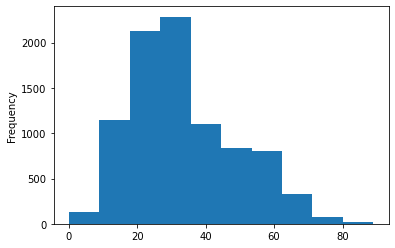

In [6]:
#checking distribution of age category
df['AGE'].plot(kind='hist');

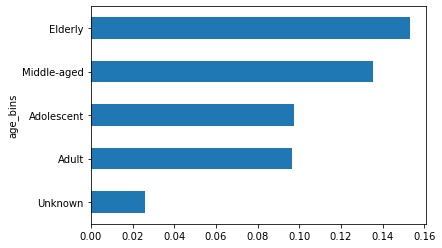

In [7]:
### Binning AGE into 20 year buckets:

def age_bins(row):
    if row['AGE'] <= 20:
        return 'Adolescent'
    elif 20 < row['AGE'] <= 40:
        return 'Adult'
    elif 40 < row['AGE'] <= 60:
        return 'Middle-aged'
    elif 60 < row['AGE']:
        return 'Elderly'
    else:
        return 'Unknown'
    

df['age_bins'] = df.apply(age_bins,axis=1)

df.groupby(by=['age_bins'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

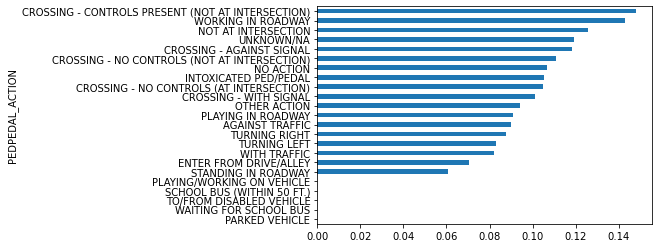

In [8]:
#checking severe injury rate by biker action category
df.groupby(by=['PEDPEDAL_ACTION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

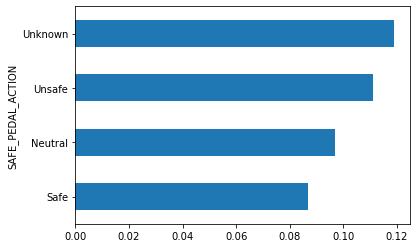

In [9]:
### Binning pedpedal action:

df.loc[df['PEDPEDAL_ACTION'] == 'WITH TRAFFIC', 'SAFE_PEDAL_ACTION'] = 'Safe'
df.loc[df['PEDPEDAL_ACTION'] == 'TURNING LEFT', 'SAFE_PEDAL_ACTION'] = 'Safe'
df.loc[df['PEDPEDAL_ACTION'] == 'TURNING RIGHT', 'SAFE_PEDAL_ACTION'] = 'Safe'
df.loc[df['PEDPEDAL_ACTION'] == 'CROSSING - WITH SIGNAL', 'SAFE_PEDAL_ACTION'] = 'Safe'
df.loc[df['PEDPEDAL_ACTION'] == 'ENTER FROM DRIVE/ALLEY', 'SAFE_PEDAL_ACTION'] = 'Safe'
df.loc[df['PEDPEDAL_ACTION'] == 'CROSSING - NO CONTROLS (AT INTERSECTION)', 'SAFE_PEDAL_ACTION'] = 'Safe'

df.loc[df['PEDPEDAL_ACTION'] == 'NO ACTION', 'SAFE_PEDAL_ACTION'] = 'Neutral'
df.loc[df['PEDPEDAL_ACTION'] == 'OTHER ACTION', 'SAFE_PEDAL_ACTION'] = 'Neutral'
df.loc[df['PEDPEDAL_ACTION'] == 'STANDING IN ROADWAY', 'SAFE_PEDAL_ACTION'] = 'Neutral'
df.loc[df['PEDPEDAL_ACTION'] == 'PARKED VEHICLE', 'SAFE_PEDAL_ACTION'] = 'Neutral'
df.loc[df['PEDPEDAL_ACTION'] == 'WAITING FOR SCHOOL BUS', 'SAFE_PEDAL_ACTION'] = 'Neutral'
df.loc[df['PEDPEDAL_ACTION'] == 'SCHOOL BUS (WITHIN 50 FT.)', 'SAFE_PEDAL_ACTION'] = 'Neutral'

df.loc[df['PEDPEDAL_ACTION'] == 'CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION)', 'SAFE_PEDAL_ACTION'] = 'Unsafe'
df.loc[df['PEDPEDAL_ACTION'] == 'AGAINST TRAFFIC', 'SAFE_PEDAL_ACTION'] = 'Unsafe'
df.loc[df['PEDPEDAL_ACTION'] == 'CROSSING - AGAINST SIGNAL', 'SAFE_PEDAL_ACTION'] = 'Unsafe'
df.loc[df['PEDPEDAL_ACTION'] == 'CROSSING - NO CONTROLS (NOT AT INTERSECTION)', 'SAFE_PEDAL_ACTION'] = 'Unsafe'
df.loc[df['PEDPEDAL_ACTION'] == 'NOT AT INTERSECTION', 'SAFE_PEDAL_ACTION'] = 'Unsafe'
df.loc[df['PEDPEDAL_ACTION'] == 'INTOXICATED PED/PEDAL', 'SAFE_PEDAL_ACTION'] = 'Unsafe'
df.loc[df['PEDPEDAL_ACTION'] == 'PLAYING IN ROADWAY', 'SAFE_PEDAL_ACTION'] = 'Unsafe'
df.loc[df['PEDPEDAL_ACTION'] == 'WORKING IN ROADWAY', 'SAFE_PEDAL_ACTION'] = 'Unsafe'
df.loc[df['PEDPEDAL_ACTION'] == 'PLAYING/WORKING ON VEHICLE', 'SAFE_PEDAL_ACTION'] = 'Unsafe'
df.loc[df['PEDPEDAL_ACTION'] == 'TO/FROM DISABLED VEHICLE', 'SAFE_PEDAL_ACTION'] = 'Unsafe'

df.loc[df['PEDPEDAL_ACTION'] == 'UNKNOWN/NA', 'SAFE_PEDAL_ACTION'] = 'Unknown'

df.groupby(by=['SAFE_PEDAL_ACTION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

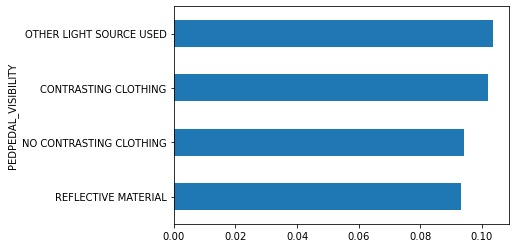

In [10]:
#checking severe injury rate by biker visibility category
df.groupby(by=['PEDPEDAL_VISIBILITY'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

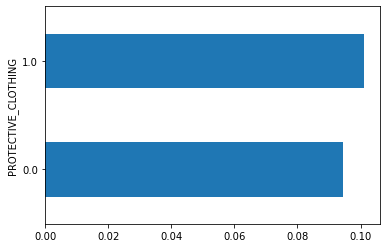

In [11]:
### Binning pedpedal visibility:

df.loc[df['PEDPEDAL_VISIBILITY'] == 'REFLECTIVE MATERIAL', 'PROTECTIVE_CLOTHING'] = 1
df.loc[df['PEDPEDAL_VISIBILITY'] == 'OTHER LIGHT SOURCE USED', 'PROTECTIVE_CLOTHING'] = 1
df.loc[df['PEDPEDAL_VISIBILITY'] == 'CONTRASTING CLOTHING', 'PROTECTIVE_CLOTHING'] = 1

df.loc[df['PEDPEDAL_VISIBILITY'] == 'NO CONTRASTING CLOTHING', 'PROTECTIVE_CLOTHING'] = 0

df.groupby(by=['PROTECTIVE_CLOTHING'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

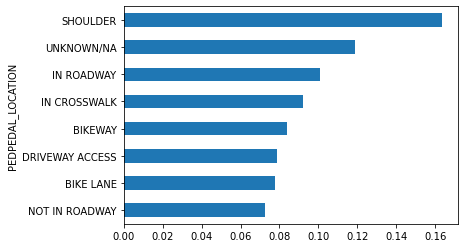

In [12]:
#checking severe injury rate by biker location category
df.groupby(by=['PEDPEDAL_LOCATION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

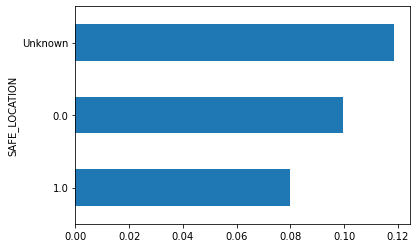

In [13]:
### Binning pedpeal location:

df.loc[df['PEDPEDAL_LOCATION'] == 'BIKEWAY', 'SAFE_LOCATION'] = 1
df.loc[df['PEDPEDAL_LOCATION'] == 'BIKE LANE', 'SAFE_LOCATION'] = 1
df.loc[df['PEDPEDAL_LOCATION'] == 'NOT IN ROADWAY', 'SAFE_LOCATION'] = 1
df.loc[df['PEDPEDAL_LOCATION'] == 'DRIVEWAY ACCESS', 'SAFE_LOCATION'] = 1

df.loc[df['PEDPEDAL_LOCATION'] == 'IN CROSSWALK', 'SAFE_LOCATION'] = 0
df.loc[df['PEDPEDAL_LOCATION'] == 'SHOULDER', 'SAFE_LOCATION'] = 0
df.loc[df['PEDPEDAL_LOCATION'] == 'IN ROADWAY', 'SAFE_LOCATION'] = 0

df.loc[df['PEDPEDAL_LOCATION'] == 'UNKNOWN/NA', 'SAFE_LOCATION'] = 'Unknown'

df.groupby(by=['SAFE_LOCATION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

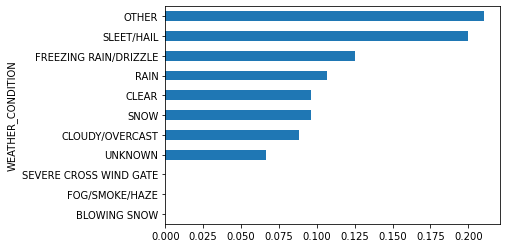

In [14]:
#checking severe injury rate by weather condition category
df.groupby(by=['WEATHER_CONDITION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

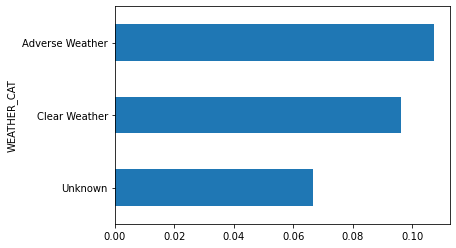

In [15]:
### Encoding WEATHER_CONDITION as categorical variables

def weather_rating(row):  
    if (row['WEATHER_CONDITION'] == 'CLEAR' or row['WEATHER_CONDITION'] == 'CLOUDY/OVERCAST'):
        return 'Clear Weather'
    elif row['WEATHER_CONDITION'] != 'UNKNOWN':
        return 'Adverse Weather'
    return 'Unknown'

df['WEATHER_CAT'] = df.apply(lambda row: weather_rating(row), axis=1)

df.groupby(by=['WEATHER_CAT'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

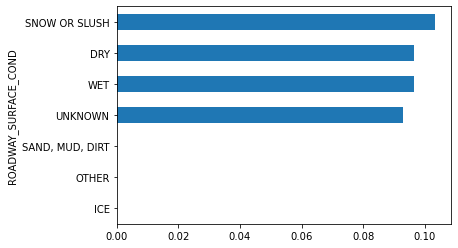

In [16]:
#checking severe injury rate by roadway surface condition category
df.groupby(by=['ROADWAY_SURFACE_COND'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

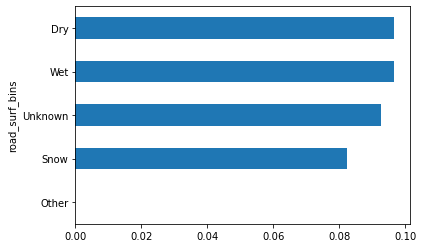

In [17]:
### Encoding ROADWAY_SURFACE_COND as categorical variables

def road_surf_bins(row):
    other = ['OTHER', 'SAND,MUD,DIRT']
    dry = ['DRY']
    wet = ['WET']
    snow = ['SNOW OR SLUSH','ICE']
    unknown = ['UNKNOWN']
    if row['ROADWAY_SURFACE_COND'] in other:
        return 'Other'
    if row['ROADWAY_SURFACE_COND'] in dry:
        return 'Dry'
    if row['ROADWAY_SURFACE_COND'] in wet:
        return 'Wet'
    if row['ROADWAY_SURFACE_COND'] in snow:
        return 'Snow'
    if row['ROADWAY_SURFACE_COND'] in unknown:
        return 'Unknown'
    else:
        return 'Unknown'
    

df['road_surf_bins'] = df.apply(road_surf_bins,axis=1)

df.groupby(by=['road_surf_bins'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

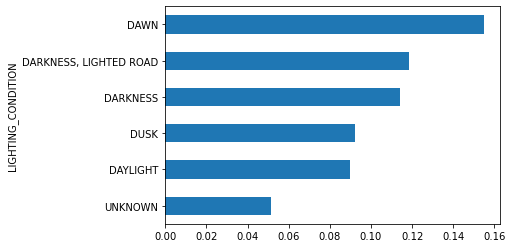

In [18]:
#checking severe injury rate by lighting condition category
df.groupby(by=['LIGHTING_CONDITION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

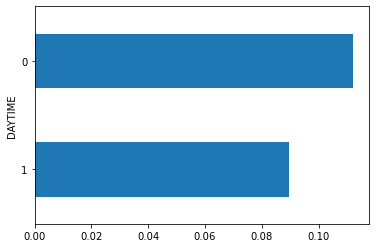

In [19]:
### Encoding LIGHTING_CONDITION as binary values (DAYTIME vs. NIGHTTIME)

df['DAYTIME'] = 1
df.loc[df['LIGHTING_CONDITION'] != 'DAYLIGHT', 'DAYTIME'] = 0

df.groupby(by=['DAYTIME'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

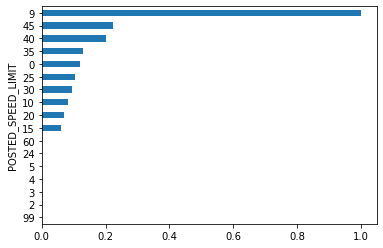

In [20]:
#checking severe injury rate by posted speed limit category
df.groupby(by=['POSTED_SPEED_LIMIT'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

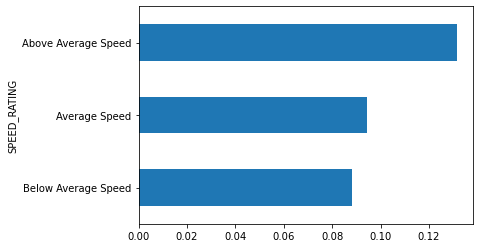

In [21]:
### Encoding POSTED_SPEED_LIMIT as SPEED_RATING w/ ordinal values with 30 as the threshold

def speed_rating(row):  
    if row['POSTED_SPEED_LIMIT'] < 30:
        return 'Below Average Speed'
    elif row['POSTED_SPEED_LIMIT'] == 30:
        return 'Average Speed'
    elif row['POSTED_SPEED_LIMIT'] > 30:
        return 'Above Average Speed'
    return 'Unknown'

df['SPEED_RATING'] = df.apply(lambda row: speed_rating(row), axis=1)

df.groupby(by=['SPEED_RATING'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

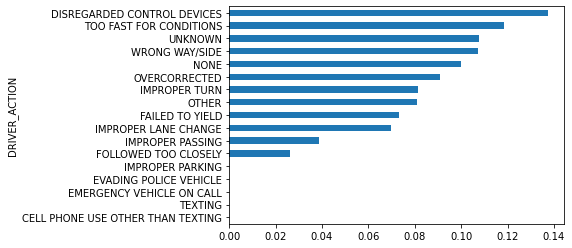

In [22]:
#checking severe injury rate by driver action category
df.groupby(by=['DRIVER_ACTION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

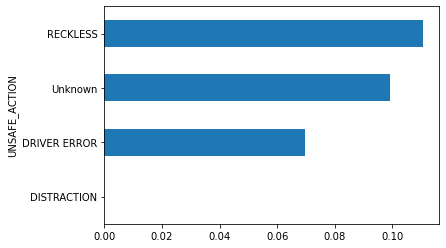

In [23]:
### Encoding DRIVER_ACTION as categorical variables

df.loc[df['DRIVER_ACTION'] == 'DISREGARDED CONTROL DEVICES', 'UNSAFE_ACTION'] = 'RECKLESS'
df.loc[df['DRIVER_ACTION'] == 'FOLLOWED TOO CLOSELY', 'UNSAFE_ACTION'] = 'RECKLESS'
df.loc[df['DRIVER_ACTION'] == 'EVADING POLICE VEHICLE', 'UNSAFE_ACTION'] = 'RECKLESS'
df.loc[df['DRIVER_ACTION'] == 'TOO FAST FOR CONDITIONS', 'UNSAFE_ACTION'] = 'RECKLESS'
df.loc[df['DRIVER_ACTION'] == 'WRONG WAY/SIDE', 'UNSAFE_ACTION'] = 'RECKLESS'

df.loc[df['DRIVER_ACTION'] == 'TEXTING', 'UNSAFE_ACTION'] = 'DISTRACTION'
df.loc[df['DRIVER_ACTION'] == 'CELL PHONE USE OTHER THAN TEXTING', 'UNSAFE_ACTION'] = 'DISTRACTION'

df.loc[df['DRIVER_ACTION'] == 'IMPROPER PARKING', 'UNSAFE_ACTION'] = 'DRIVER ERROR'
df.loc[df['DRIVER_ACTION'] == 'OVERCORRECTED', 'UNSAFE_ACTION'] = 'DRIVER ERROR'
df.loc[df['DRIVER_ACTION'] == 'EMERGENCY VEHICLE ON CALL', 'UNSAFE_ACTION'] = 'DRIVER ERROR'
df.loc[df['DRIVER_ACTION'] == 'IMPROPER TURN', 'UNSAFE_ACTION'] = 'DRIVER ERROR'
df.loc[df['DRIVER_ACTION'] == 'IMPROPER LANE CHANGE', 'UNSAFE_ACTION'] = 'DRIVER ERROR'
df.loc[df['DRIVER_ACTION'] == 'IMPROPER PASSING', 'UNSAFE_ACTION'] = 'DRIVER ERROR'
df.loc[df['DRIVER_ACTION'] == 'FAILED TO YIELD', 'UNSAFE_ACTION'] = 'DRIVER ERROR'

df.loc[df['DRIVER_ACTION'] == 'NONE', 'UNSAFE_ACTION'] = 'Unknown'
df.loc[df['DRIVER_ACTION'] == 'OTHER', 'UNSAFE_ACTION'] = 'Unknown'
df.loc[df['DRIVER_ACTION'] == 'UNKNOWN', 'UNSAFE_ACTION'] = 'Unknown' 

df.groupby(by=['UNSAFE_ACTION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

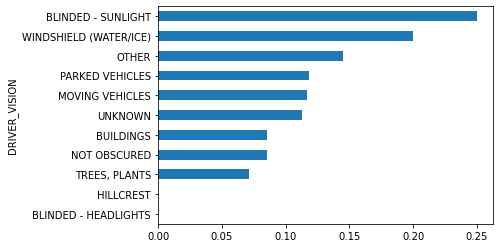

In [24]:
#checking severe injury rate by driver vision category
df.groupby(by=['DRIVER_VISION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

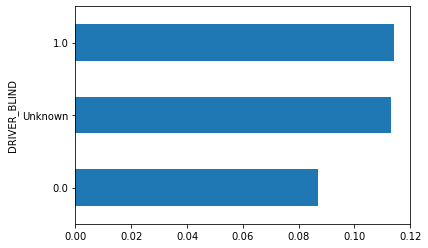

In [25]:
### Binning DRIVER_VISION into binary:

df.loc[df['DRIVER_VISION'] == 'MOVING VEHICLES', 'DRIVER_BLIND'] = 1
df.loc[df['DRIVER_VISION'] == 'PARKED VEHICLES', 'DRIVER_BLIND'] = 1
df.loc[df['DRIVER_VISION'] == 'BUILDINGS', 'DRIVER_BLIND'] = 1
df.loc[df['DRIVER_VISION'] == 'TREES, PLANTS', 'DRIVER_BLIND'] = 1
df.loc[df['DRIVER_VISION'] == 'WINDSHIELD (WATER/ICE)', 'DRIVER_BLIND'] = 1
df.loc[df['DRIVER_VISION'] == 'BLINDED - SUNLIGHT', 'DRIVER_BLIND'] = 1
df.loc[df['DRIVER_VISION'] == 'BLINDED - HEADLIGHTS', 'DRIVER_BLIND'] = 1
df.loc[df['DRIVER_VISION'] == 'HILLCREST', 'DRIVER_BLIND'] = 1

df.loc[df['DRIVER_VISION'] == 'NOT OBSCURED', 'DRIVER_BLIND'] = 0
df.loc[df['DRIVER_VISION'] == 'OTHER', 'DRIVER_BLIND'] = 0

df.loc[df['DRIVER_VISION'] == 'UNKNOWN', 'DRIVER_BLIND'] = 'Unknown'

df.groupby(by=['DRIVER_BLIND'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

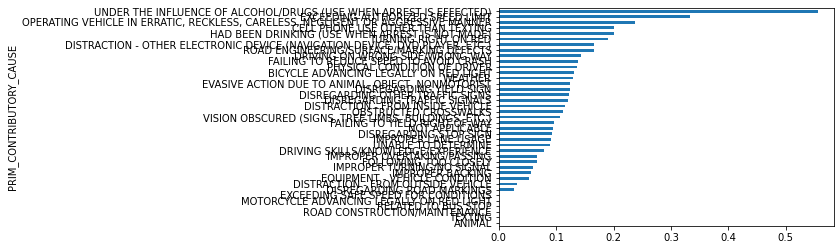

In [26]:
#checking severe injury rate by primary contributory cause of the crash category
df.groupby(by=['PRIM_CONTRIBUTORY_CAUSE'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

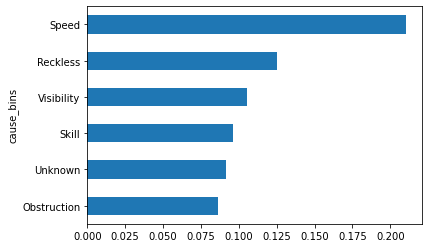

In [27]:
### Encoding Primary and Secondary Cause Classifier

def cause_bins(row):
    cause_obstruction = ['EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST', 'ROAD CONSTRUCTION/MAINTENANCE', 
                         'RELATED TO BUS STOP', 'OBSTRUCTED CROSSWALKS', 'ANIMAL']
    cause_not_applicable = ['UNABLE TO DETERMINE', 'NOT APPLICABLE']
    cause_reckless = ['EQUIPMENT - VEHICLE CONDITION', 'PHYSICAL CONDITION OF DRIVER', 'IMPROPER BACKING', 
                      'TEXTING', 'DISTRACTION - FROM INSIDE VEHICLE', 'IMPROPER OVERTAKING/PASSING', 
                      'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)', 
                      'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)', 
                      'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER', 
                      'CELL PHONE USE OTHER THAN TEXTING', 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)']
    cause_skill = ['IMPROPER LANE USAGE', 'DISREGARDING TRAFFIC SIGNALS', 'DISREGARDING ROAD MARKINGS', 
                   'FAILING TO YIELD RIGHT-OF-WAY', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 
                   'IMPROPER TURNING/NO SIGNAL', 'TURNING RIGHT ON RED', 'FOLLOWING TOO CLOSELY', 
                   'DISREGARDING STOP SIGN', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', 'FAILING TO REDUCE SPEED TO AVOID CRASH', 
                   'DISREGARDING OTHER TRAFFIC SIGNS', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT', 'DISREGARDING YIELD SIGN']
    cause_speed = ['EXCEEDING SAFE SPEED FOR CONDITIONS', 'EXCEEDING AUTHORIZED SPEED LIMIT']
    cause_visibility = ['VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 
                        'WEATHER', 'DISTRACTION - FROM OUTSIDE VEHICLE']
    if row['PRIM_CONTRIBUTORY_CAUSE'] in cause_obstruction:
        return 'Obstruction'
    if row['PRIM_CONTRIBUTORY_CAUSE'] in cause_reckless:
        return 'Reckless'
    if row['PRIM_CONTRIBUTORY_CAUSE'] in cause_skill:
        return 'Skill'
    if row['PRIM_CONTRIBUTORY_CAUSE'] in cause_speed:
        return 'Speed'
    if row['PRIM_CONTRIBUTORY_CAUSE'] in cause_visibility:
        return 'Visibility'
    if row['PRIM_CONTRIBUTORY_CAUSE'] in cause_not_applicable and row['SEC_CONTRIBUTORY_CAUSE'] in cause_not_applicable:
        if row['SEC_CONTRIBUTORY_CAUSE'] in cause_obstruction:
            return 'Obstruction'
        if row['SEC_CONTRIBUTORY_CAUSE'] in cause_reckless:
            return 'Reckless'
        if row['SEC_CONTRIBUTORY_CAUSE'] in cause_skill:
            return 'Skill'
        if row['SEC_CONTRIBUTORY_CAUSE'] in cause_speed:
            return 'Speed'
        if row['SEC_CONTRIBUTORY_CAUSE'] in cause_visibility:
            return 'Visibility'
    if row['PRIM_CONTRIBUTORY_CAUSE'] in cause_not_applicable:
        return 'Unknown' 
    else:
        return 'Unknown'
    

df['cause_bins'] = df.apply(cause_bins,axis=1)

df.groupby(by=['cause_bins'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

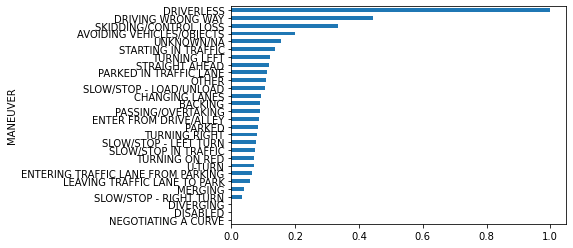

In [28]:
#checking severe injury rate by driver maneuver category
df.groupby(by=['MANEUVER'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

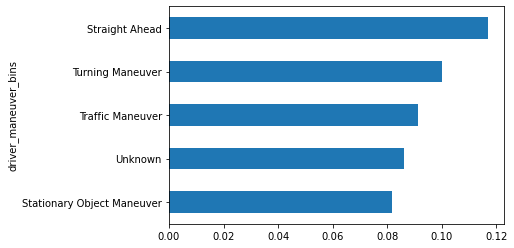

In [29]:
## Binning maneuver

def driver_maneuver(row):
    man_straight = ['STRAIGHT AHEAD']
    man_turn = ['TURNING LEFT', 'TURNING RIGHT', 'U-TURN', 
            'SLOW/STOP - RIGHT TURN', 'SLOW/STOP - LEFT TURN',
            'AVOIDING VEHICLES/OBJECTS', 'TURNING ON RED', 'NEGOTIATING A CURVE']
    man_traffic = ['PASSING/OVERTAKING', 'MERGING', 'ENTER FROM DRIVE/ALLEY', 'ENTERING TRAFFIC LANE FROM PARKING', 
               'LEAVING TRAFFIC LANE TO PARK', 'CHANGING LANES', 'STARTING IN TRAFFIC', 'BACKING', 
               'SLOW/STOP - LOAD/UNLOAD', 'DRIVING WRONG WAY', 'SKIDDING/CONTROL LOSS']
    man_stationary = ['PARKED', 'SLOW/STOP IN TRAFFIC', 'PARKED IN TRAFFIC LANE']
    man_unknown = ['UNKNOWN/NA', 'OTHER', 'DRIVERLESS', 'DISABLED', 'DIVERGING']
    if row['MANEUVER'] in man_straight:
        return 'Straight Ahead'
    if row['MANEUVER'] in man_turn:
        return 'Turning Maneuver'
    if row['MANEUVER'] in man_traffic:
        return 'Traffic Maneuver'
    if row['MANEUVER'] in man_stationary:
        return 'Stationary Object Maneuver'
    if row['MANEUVER'] in man_unknown:
        return 'Unknown'
    else:
        return 'Unknown'
    
df['driver_maneuver_bins'] = df.apply(driver_maneuver,axis=1)

df.groupby(by=['driver_maneuver_bins'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

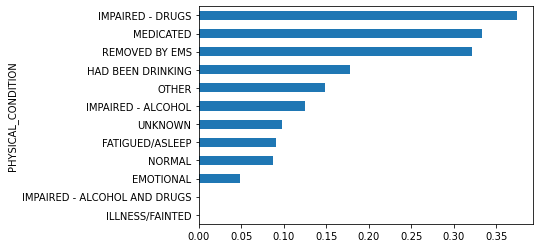

In [30]:
#checking severe injury rate by driver physical condition category
df.groupby(by=['PHYSICAL_CONDITION'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

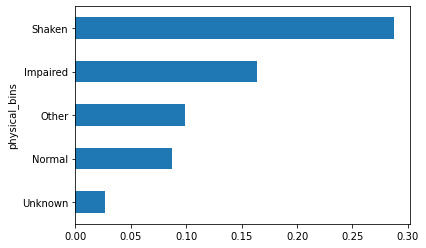

In [31]:
## Bin Physical Condition

def physical_bins(row):
    impaired = ['HAD BEEN DRINKING','FATIGUED/ASLEEP','IMPAIRED - ALCOHOL','IMPAIRED - DRUGS','MEDICATED','IMPAIRED - ALCOHOL AND DRUGS']
    normal = ['NORMAL']
    shaken = ['REMOVED BY EMS','ILLNESS/FAINTED','EMOTIONAL']
    other = ['UNKNOWN','OTHER']
    if row['PHYSICAL_CONDITION'] in impaired:
        return 'Impaired'
    if row['PHYSICAL_CONDITION'] in normal:
        return 'Normal'
    if row['PHYSICAL_CONDITION'] in shaken:
        return 'Shaken'
    if row['PHYSICAL_CONDITION'] in other:
        return 'Other'
    else:
        return 'Unknown'
    

df['physical_bins'] = df.apply(physical_bins,axis=1)

df.groupby(by=['physical_bins'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

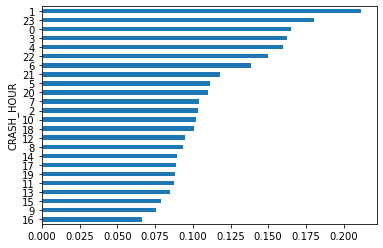

In [32]:
#checking severe injury rate by crash hour category
df.groupby(by=['CRASH_HOUR'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

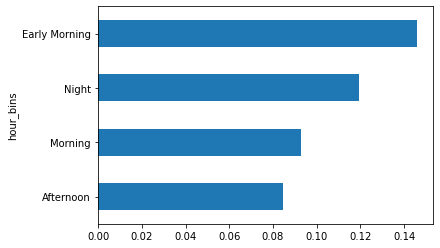

In [33]:
## Bin Hour in the Day

def hour_bins(row):
    if 1 <= row['CRASH_HOUR'] <= 6:
        return 'Early Morning'
    if 7 <= row['CRASH_HOUR'] <= 12:
        return 'Morning'
    if 13 <= row['CRASH_HOUR'] <= 18:
        return 'Afternoon'
    if 19 <= row['CRASH_HOUR'] <= 23 or row['CRASH_HOUR'] == 0:
        return 'Night'
    else:
        return 'Unknown'
    

df['hour_bins'] = df.apply(hour_bins,axis=1)

df.groupby(by=['hour_bins'])['INJURY_BAD'].mean().sort_values().plot(kind='barh');

In [34]:
#create new dataframe with newly created binned columns. convert appropriate columns to float types
bf = df.iloc[:,-16:]
bf['SEX'] = df['SEX']
bf['INJURY_BAD'] = bf['INJURY_BAD'].astype(float)
bf['PROTECTIVE_CLOTHING'] = bf['PROTECTIVE_CLOTHING'].astype(float)

In [35]:
#turn this new dataframe into a csv
bf.to_csv("bikers_semi_final_v2.csv")

In [36]:
### Importing packages for data analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)

df = pd.read_csv("bikers_semi_final_v2.csv")

## Deal with Unknown/Missing Values

In [37]:
#drop unnecessary column
df = df.drop(columns=['Unnamed: 0'])

In [38]:
#replace all NAs with Unknown
df = df.fillna("Unknown")

In [39]:
#check 'Unknown' counts for all columns
for col in df.columns:
    count = (df[col] == 'Unknown').sum()
    print(f"{col}: {count}")

INJURY_BAD: 2
HELMET_USED: 1051
age_bins: 1550
SAFE_PEDAL_ACTION: 1195
PROTECTIVE_CLOTHING: 2
SAFE_LOCATION: 499
WEATHER_CAT: 271
road_surf_bins: 583
DAYTIME: 0
SPEED_RATING: 0
UNSAFE_ACTION: 8379
DRIVER_BLIND: 3936
cause_bins: 4708
driver_maneuver_bins: 4432
physical_bins: 190
hour_bins: 0
SEX: 145


In [40]:
#create a new dataframe that drops one column with majority of values 'Unknown'
df2 = df.drop(columns=['UNSAFE_ACTION'])

In [41]:
#gets rid of rest of rows with Unknown data
df2 = df2[~(df2 == 'Unknown').any(axis=1)]

In [42]:
#converts appropriate columns to float types
df2['INJURY_BAD'] = df2['INJURY_BAD'].astype(float)
df2['HELMET_USED'] = df2['HELMET_USED'].astype(float)
df2['PROTECTIVE_CLOTHING'] = df2['PROTECTIVE_CLOTHING'].astype(float)
df2['SAFE_LOCATION'] = df2['SAFE_LOCATION'].astype(float)
df2['DRIVER_BLIND'] = df2['DRIVER_BLIND'].astype(float)

In [43]:
#checks dataframe data count, which is about 2000 data points
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2124 entries, 0 to 10384
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   INJURY_BAD            2124 non-null   float64
 1   HELMET_USED           2124 non-null   float64
 2   age_bins              2124 non-null   object 
 3   SAFE_PEDAL_ACTION     2124 non-null   object 
 4   PROTECTIVE_CLOTHING   2124 non-null   float64
 5   SAFE_LOCATION         2124 non-null   float64
 6   WEATHER_CAT           2124 non-null   object 
 7   road_surf_bins        2124 non-null   object 
 8   DAYTIME               2124 non-null   int64  
 9   SPEED_RATING          2124 non-null   object 
 10  DRIVER_BLIND          2124 non-null   float64
 11  cause_bins            2124 non-null   object 
 12  driver_maneuver_bins  2124 non-null   object 
 13  physical_bins         2124 non-null   object 
 14  hour_bins             2124 non-null   object 
 15  SEX                 

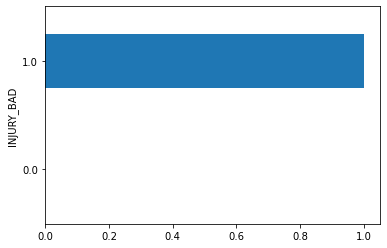

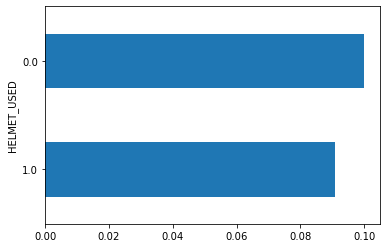

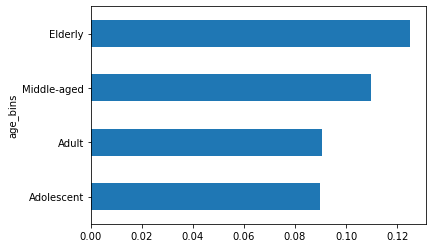

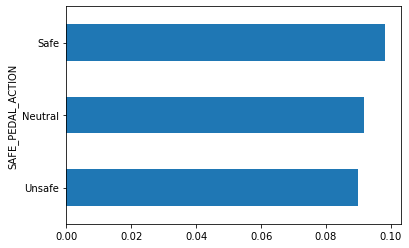

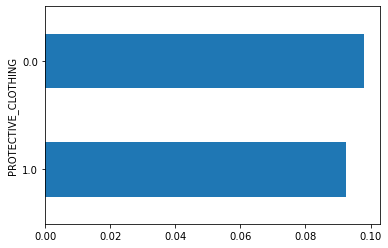

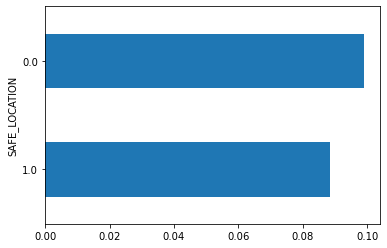

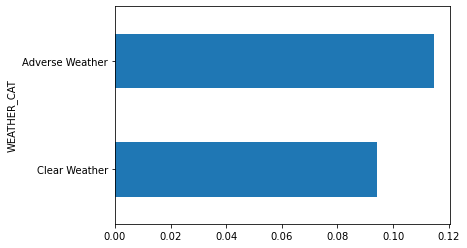

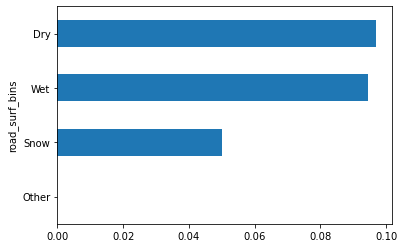

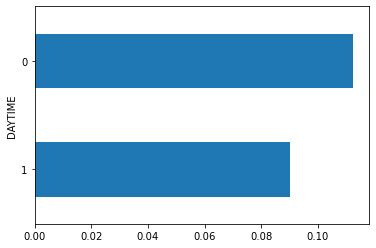

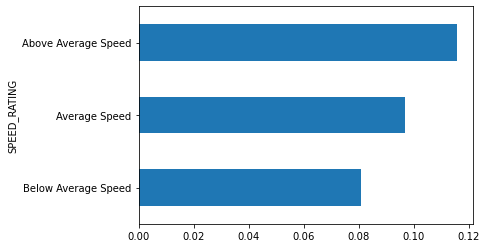

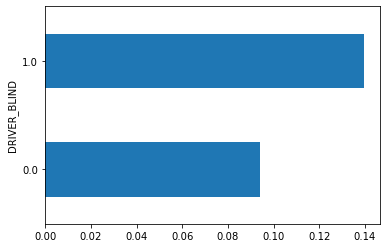

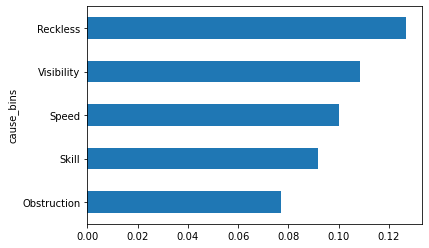

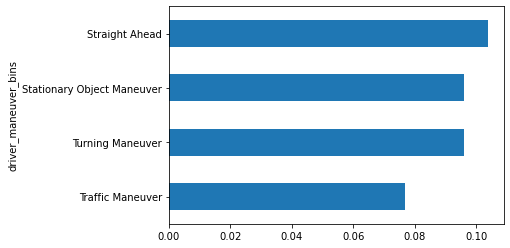

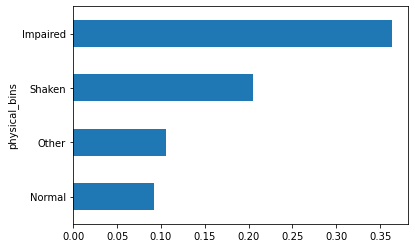

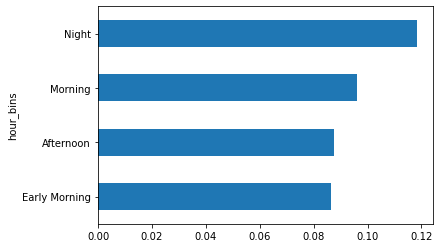

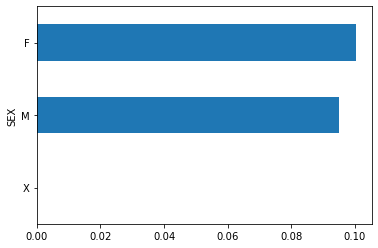

In [44]:
#checks severe injury rate by category for each column in new dataframe
for col in df2.columns:
    df2.groupby(by=[col])['INJURY_BAD'].mean().sort_values().plot(kind='barh');
    plt.show()

In [45]:
#creates new dataframe that drops columns with most 'Unknown' values before dropping Unknowns
#in order to preserve more data
df3 = df.drop(columns=['UNSAFE_ACTION', 'DRIVER_BLIND', 'cause_bins', 'driver_maneuver_bins'])

In [46]:
#drops Unknowns from new dataframe
df3 = df3[~(df3 == 'Unknown').any(axis=1)]

In [47]:
#checks data counts in new dataframe, which is almost 7000 data points
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6807 entries, 0 to 10393
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   INJURY_BAD           6807 non-null   object
 1   HELMET_USED          6807 non-null   object
 2   age_bins             6807 non-null   object
 3   SAFE_PEDAL_ACTION    6807 non-null   object
 4   PROTECTIVE_CLOTHING  6807 non-null   object
 5   SAFE_LOCATION        6807 non-null   object
 6   WEATHER_CAT          6807 non-null   object
 7   road_surf_bins       6807 non-null   object
 8   DAYTIME              6807 non-null   int64 
 9   SPEED_RATING         6807 non-null   object
 10  physical_bins        6807 non-null   object
 11  hour_bins            6807 non-null   object
 12  SEX                  6807 non-null   object
dtypes: int64(1), object(12)
memory usage: 744.5+ KB


In [48]:
#converts appropriate columns to float data type
df3['INJURY_BAD'] = df3['INJURY_BAD'].astype(float)
df3['HELMET_USED'] = df3['HELMET_USED'].astype(float)
df3['PROTECTIVE_CLOTHING'] = df3['PROTECTIVE_CLOTHING'].astype(float)
df3['SAFE_LOCATION'] = df3['SAFE_LOCATION'].astype(float)

In [49]:
#checks distribution of severe injury target variable
df3['INJURY_BAD'].value_counts()

0.0    6096
1.0     711
Name: INJURY_BAD, dtype: int64

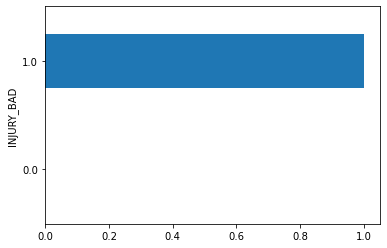

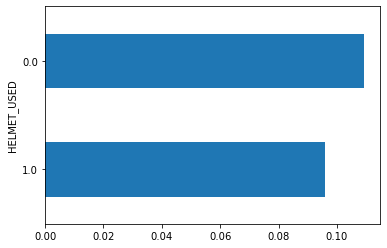

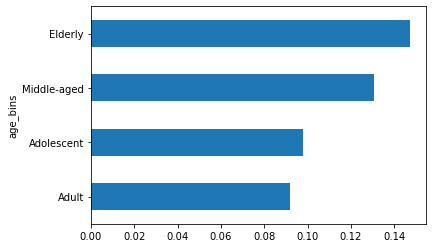

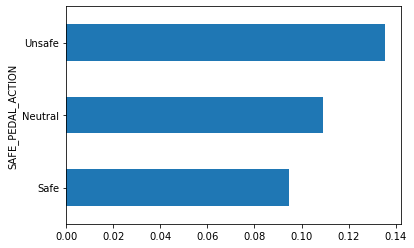

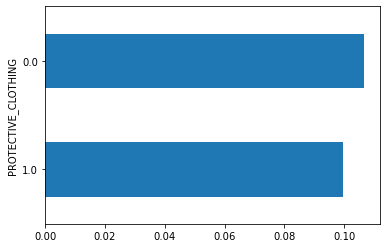

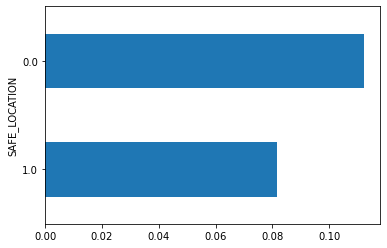

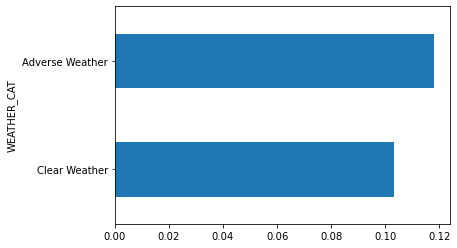

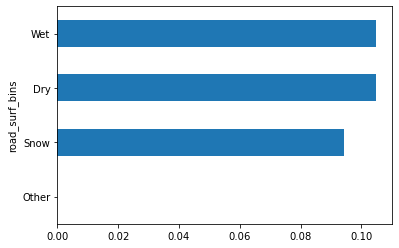

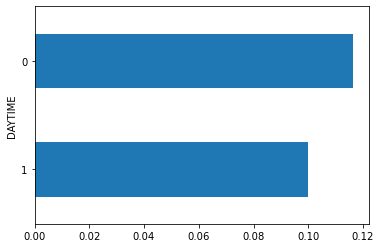

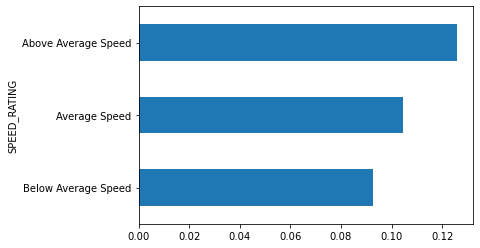

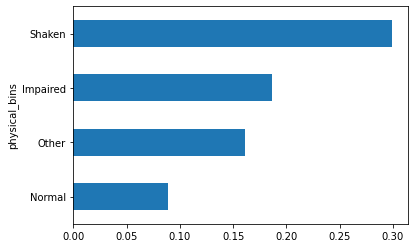

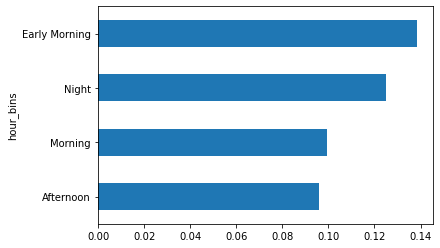

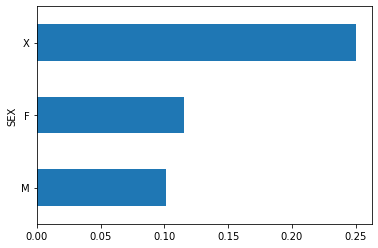

In [50]:
#checks severe injury rate by category for each column in new dataframe
for col in df3.columns:
    df3.groupby(by=[col])['INJURY_BAD'].mean().sort_values().plot(kind='barh');
    plt.show()

In [51]:
#makes 2 new csvs, one for the 2000 data points and one for the 7000 data points
df2.to_csv("small_data.csv")
df3.to_csv("big_data.csv")

In [52]:
#import pandas
import pandas as pd

In [53]:
#read in csv file
df = pd.read_csv('big_data.csv')

In [54]:
#check data count, data types, columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6807 non-null   int64  
 1   INJURY_BAD           6807 non-null   float64
 2   HELMET_USED          6807 non-null   float64
 3   age_bins             6807 non-null   object 
 4   SAFE_PEDAL_ACTION    6807 non-null   object 
 5   PROTECTIVE_CLOTHING  6807 non-null   float64
 6   SAFE_LOCATION        6807 non-null   float64
 7   WEATHER_CAT          6807 non-null   object 
 8   road_surf_bins       6807 non-null   object 
 9   DAYTIME              6807 non-null   int64  
 10  SPEED_RATING         6807 non-null   object 
 11  physical_bins        6807 non-null   object 
 12  hour_bins            6807 non-null   object 
 13  SEX                  6807 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 744.6+ KB


## A Little Final Data Tuning before Modeling

In [55]:
#drop columns we won't use. first is unnecessary, second not significant, third is too similar to hour_bins
df = df.drop(['Unnamed: 0','road_surf_bins','DAYTIME'],axis=1)

In [56]:
#drop 3rd sex 'X', very small number in this sex category
df = df.loc[df['SEX'] != 'X']

In [57]:
#drop 'Shaken' category in driver physical condition, which is too influenced by 'Taken to EMS'.
#Tells us less about driver at time of crash and more about driver after the crash (less cause, more result).
#Of course more likely to have a bad crash if the driver also needed to be hospitalized.
df = df.loc[df['physical_bins'] != 'Shaken']

In [58]:
#check to see if 'X' was dropped from sex column
df['SEX'].value_counts()

M    5202
F    1369
Name: SEX, dtype: int64

In [59]:
#check to see all changes were made correctly and how many values were dropped as a result.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6571 entries, 0 to 6806
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   INJURY_BAD           6571 non-null   float64
 1   HELMET_USED          6571 non-null   float64
 2   age_bins             6571 non-null   object 
 3   SAFE_PEDAL_ACTION    6571 non-null   object 
 4   PROTECTIVE_CLOTHING  6571 non-null   float64
 5   SAFE_LOCATION        6571 non-null   float64
 6   WEATHER_CAT          6571 non-null   object 
 7   SPEED_RATING         6571 non-null   object 
 8   physical_bins        6571 non-null   object 
 9   hour_bins            6571 non-null   object 
 10  SEX                  6571 non-null   object 
dtypes: float64(4), object(7)
memory usage: 616.0+ KB


# Modeling

Our target variable was binary: did the biker have a severe injury or not? We defined severe to mean an incapacitating or a fatal injury.

We ran 3 types of machine learning models, which included driver characteristics (such as were they impaired), biker characteristics (such as age and helmet usage), and crash conditions (such as time of day and weather).

From our models we were able to extract the most important features and estimate their impact on the likelihood of severe cyclist injuries.

## Preparing Data for Modeling

In [60]:
#import train test split and decision tree to first determine X variable feature importances
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [61]:
#create X and y variables, perform train test split
y = df['INJURY_BAD']
X = df.drop('INJURY_BAD',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=312)

In [62]:
#import one hot encoder
from sklearn.preprocessing import OneHotEncoder

In [63]:
#one hot encode X train and X test data sets
ohe = OneHotEncoder()
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

In [64]:
#import random undersampler and randomly undersample X_train majority class (non-severe injuries)
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(random_state=312)
X_u, y_u = under.fit_resample(X_train_encoded,y_train)

## Decision Tree

We used this decision tree model as a way to look at feature importance. We used the most important feature derived from this model, driver physical condition, in our simple logistic regression model. We used a max depth of 7 as was suggested by the grid search to maximize recall, our target metric. We chose recall because we wished to minimize the number of false negatives (failing to predict a severe biker injury). At the same time, we did also wish to secondarily minimize false positives (predicting a severe biker injury when there wasn't one), so we also looked at precision.

The decision tree model had a recall score of .474 in the cross validation and .546 in the test set.

In [65]:
#instantiate decision tree classifier, fit it on train data that was one hot encoded and randomly undersampled
dt = DecisionTreeClassifier(max_depth=7,random_state=312)
dt.fit(X_u,y_u)

DecisionTreeClassifier(max_depth=7, random_state=312)

In [66]:
#import precision and recall scores. Evaluate train and test precision and recall scores
from sklearn.metrics import precision_score,recall_score

y_train_pred = dt.predict(X_u)
y_test_pred = dt.predict(X_test_encoded)

train_p = precision_score(y_u,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_u,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.6987704918032787
Test Precision: 0.1173780487804878
Train Recall: 0.682
Test Recall: 0.5460992907801419


In [67]:
#import cross validation score. Evaluate decision tree model recall performance with default 5 folds on training set
from sklearn.model_selection import cross_val_score

recall = cross_val_score(dt,X_u,y_u,scoring='recall')
recall

array([0.54, 0.44, 0.38, 0.49, 0.52])

In [68]:
#look at mean recall score from cross validation
recall.mean()

0.47400000000000003

In [69]:
#evaluate model using precision cross validation as well (though primarily focused on recall)
precision = cross_val_score(dt,X_u,y_u,scoring='precision')
precision

array([0.55670103, 0.55696203, 0.54285714, 0.54444444, 0.53608247])

In [70]:
#look at mean precision score from cross validation
precision.mean()

0.5474094235545364

In [71]:
#run a grid search for best max depth parameter on decision tree model to maximize recall
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1,30)}

grid_search = GridSearchCV(dt, param_grid, cv=5,scoring='recall')
grid_search.fit(X_u, y_u)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'max_depth': 7}

In [72]:
#look at recall score for decision tree model with best max depth (of 7)
best_score

0.47400000000000003

In [73]:
#get feature importances, save as a list
importances = list(dt.feature_importances_)

In [74]:
#turn X variables used into a dataframe with column labels
xu_df = pd.DataFrame(X_u.todense(),columns=ohe.get_feature_names())

In [75]:
#turn the X variable columns names into a list
names = list(xu_df.columns)

In [76]:
#zip the two lists into a dictionary of column names and feature importances
importance_names = dict(zip(names,importances))

In [77]:
#look to see which columns had the highest feature importances
importance_names

{'x0_0.0': 0.03783275124411903,
 'x0_1.0': 0.025052116799617278,
 'x1_Adolescent': 0.027740590782442277,
 'x1_Adult': 0.062187160869183626,
 'x1_Elderly': 0.008650461649008992,
 'x1_Middle-aged': 0.0,
 'x2_Neutral': 0.021526311450192154,
 'x2_Safe': 0.08214362508442999,
 'x2_Unsafe': 0.049880413957519285,
 'x3_0.0': 0.06042514599040034,
 'x3_1.0': 0.008650461649008992,
 'x4_0.0': 0.06792879833927169,
 'x4_1.0': 0.03197415524575112,
 'x5_Adverse Weather': 0.05472446809861167,
 'x5_Clear Weather': 0.01834081405009036,
 'x6_Above Average Speed': 0.049143600386040376,
 'x6_Average Speed': 0.030187609535017035,
 'x6_Below Average Speed': 0.05199753462391583,
 'x7_Impaired': 0.0,
 'x7_Normal': 0.10078439341508483,
 'x7_Other': 0.0,
 'x8_Afternoon': 0.04644363464251603,
 'x8_Early Morning': 0.010455311054789826,
 'x8_Morning': 0.011218559769133957,
 'x8_Night': 0.060871814477444754,
 'x9_F': 0.058667298395674944,
 'x9_M': 0.02317296849073565}

## Simple Logistic Regression

The simple logistic regression model serves as a baseline model. It had a recall of 0.21 on the test set.

In [78]:
#import logistic regression and minmaxscaler packages
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [79]:
#turn one hot encoded datasets back into data frames
X_train_df = pd.DataFrame(X_train_encoded.todense(),columns=ohe.get_feature_names())
X_test_df = pd.DataFrame(X_test_encoded.todense(),columns=ohe.get_feature_names())

In [80]:
#check to see if dataframe was correctly made
X_train_df

x0_0.0  x0_1.0  x1_Adolescent  x1_Adult  x1_Elderly  x1_Middle-aged  \
0        1.0     0.0            0.0       1.0         0.0             0.0   
1        1.0     0.0            0.0       0.0         0.0             1.0   
2        1.0     0.0            1.0       0.0         0.0             0.0   
3        1.0     0.0            0.0       0.0         1.0             0.0   
4        0.0     1.0            0.0       0.0         0.0             1.0   
5        1.0     0.0            0.0       1.0         0.0             0.0   
6        1.0     0.0            0.0       0.0         0.0             1.0   
7        1.0     0.0            1.0       0.0         0.0             0.0   
8        1.0     0.0            0.0       1.0         0.0             0.0   
9        1.0     0.0            0.0       0.0         0.0             1.0   
10       1.0     0.0            0.0       1.0         0.0             0.0   
11       0.0     1.0            0.0       0.0         0.0             1.0   
12       0.0     1.0            0.0       1.0         0.0             0.0   
13       0.0     1.0            0.0       1.0         0.0             0.0   
14       0.0     1.0            0.0       1.0         0.0             0.0   
15       0.0     1.0            0.0       0.0         0.0             1.0   
16       1.0     0.0            0.0       1.0         0.0             0.0   
17       0.0     1.0            0.0       1.0         0.0             0.0   
18       1.0     0.0            1.0       0.0         0.0             0.0   
19       1.0     0.0            0.0       1.0         0.0             0.0   
20       1.0     0.0            0.0       1.0         0.0             0.0   
21       1.0     0.0            0.0       1.0         0.0             0.0   
22       0.0     1.0            1.0       0.0         0.0             0.0   
23       0.0     1.0            0.0       1.0         0.0             0.0   
24       1.0     0.0            1.0       0.0         0.0             0.0   
25       1.0     0.0            0.0       1.0         0.0             0.0   
26       0.0     1.0            0.0       0.0         0.0             1.0   
27       0.0     1.0            0.0       0.0         0.0             1.0   
28       1.0     0.0            1.0       0.0         0.0             0.0   
29       0.0     1.0            0.0       1.0         0.0             0.0   
30       0.0     1.0            0.0       1.0         0.0             0.0   
31       1.0     0.0            0.0       1.0         0.0             0.0   
32       0.0     1.0            0.0       1.0         0.0             0.0   
33       0.0     1.0            0.0       0.0         1.0             0.0   
34       0.0     1.0            0.0       1.0         0.0             0.0   
35       1.0     0.0            0.0       1.0         0.0             0.0   
36       0.0     1.0            0.0       1.0         0.0             0.0   
37       0.0     1.0            0.0       1.0         0.0             0.0   
38       1.0     0.0            0.0       1.0         0.0             0.0   
39       0.0     1.0            0.0       0.0         0.0             1.0   
40       1.0     0.0            0.0       1.0         0.0             0.0   
41       1.0     0.0            0.0       0.0         1.0             0.0   
42       1.0     0.0            0.0       0.0         0.0             1.0   
43       1.0     0.0            0.0       1.0         0.0             0.0   
44       1.0     0.0            0.0       1.0         0.0             0.0   
45       0.0     1.0            0.0       0.0         0.0             1.0   
46       1.0     0.0            0.0       1.0         0.0             0.0   
47       1.0     0.0            0.0       0.0         0.0             1.0   
48       1.0     0.0            0.0       1.0         0.0             0.0   
49       0.0     1.0            0.0       1.0         0.0             0.0   
50       0.0     1.0            0.0       1.0         0.0             0.0   
51

In [81]:
#use only most important X variable physical condition (based on decision tree feature importance)
#scale train and test data
#run simple logistic regression, fit on train data
#calculate precision and recall scores for train and test sets
scaler = MinMaxScaler()
X_train_simple = X_train_df.iloc[:,-9:-6]
X_test_simple = X_test_df.iloc[:,-9:-6]
X_train_simple_scaled = scaler.fit_transform(X_train_simple)
X_test_simple_scaled = scaler.transform(X_test_simple)

log_model_simple = LogisticRegression(class_weight='balanced',random_state=312)

log_model_simple.fit(X_train_simple_scaled,y_train)

y_train_pred = log_model_simple.predict(X_train_simple_scaled)
y_test_pred = log_model_simple.predict(X_test_simple_scaled)

train_p = precision_score(y_train,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_train,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.15816326530612246
Test Precision: 0.18633540372670807
Train Recall: 0.186
Test Recall: 0.2127659574468085


## Multi-Variable Logistic Regression

Next, we ran a logistic regression with all the selected X variables in our dataset. From this model, we were able to extract the most important variables and interpret their coefficients.

This model had a recall score of .496 in cross-validation and .546 on the test set.

In [82]:
#scale data for all X variables
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

In [83]:
#instantiate multiple X variables logistic regression model
log_model = LogisticRegression(class_weight='balanced',random_state=312)

In [84]:
#fit on train set
log_model.fit(X_train_scaled,y_train)

LogisticRegression(class_weight='balanced', random_state=312)

In [85]:
#calculate precision and recall scores for train and test sets
y_train_pred = log_model.predict(X_train_scaled)
y_test_pred = log_model.predict(X_test_scaled)

train_p = precision_score(y_train,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_train,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')


Train Precision: 0.12791828793774318
Test Precision: 0.14583333333333334
Train Recall: 0.526
Test Recall: 0.5460992907801419


In [86]:
#run cross validation on train set for recall metric
recall = cross_val_score(log_model,X_train_scaled,y_train,scoring='recall')
recall

array([0.56, 0.43, 0.41, 0.53, 0.55])

In [87]:
#calculate recall mean
recall.mean()

0.496

In [88]:
#run cross valiation on train set for precision metric
precision = cross_val_score(log_model,X_train_scaled,y_train,scoring='precision')
precision

array([0.13238771, 0.11375661, 0.1025    , 0.12354312, 0.12249443])

In [89]:
#calculate precision mean
precision.mean()

0.11893637524535974

In [90]:
#create a dictionary with column names and logistic regression coefficients
coef_dict = {}
for coef, feat in zip(log_model.coef_[0,:],X_train_df.columns):
    coef_dict[feat] = coef
for i,v in coef_dict.items():
    coef_dict[i] = round(v,2)
coef_dict

{'x0_0.0': -0.04,
 'x0_1.0': 0.03,
 'x1_Adolescent': -0.09,
 'x1_Adult': -0.26,
 'x1_Elderly': 0.29,
 'x1_Middle-aged': 0.06,
 'x2_Neutral': 0.04,
 'x2_Safe': -0.18,
 'x2_Unsafe': 0.14,
 'x3_0.0': -0.01,
 'x3_1.0': 0.01,
 'x4_0.0': 0.11,
 'x4_1.0': -0.12,
 'x5_Adverse Weather': 0.09,
 'x5_Clear Weather': -0.1,
 'x6_Above Average Speed': 0.26,
 'x6_Average Speed': -0.08,
 'x6_Below Average Speed': -0.18,
 'x7_Impaired': 0.14,
 'x7_Normal': -0.36,
 'x7_Other': 0.23,
 'x8_Afternoon': -0.21,
 'x8_Early Morning': 0.2,
 'x8_Morning': -0.1,
 'x8_Night': 0.11,
 'x9_F': 0.08,
 'x9_M': -0.08}

In [91]:
#turn selected top five log odds coefficients into odds for easier interpretation in presentation
import numpy as np
selected_five = np.array([-0.36,0.29,0.26,0.2,-0.18])
np.exp(selected_five)

array([0.69767633, 1.33642749, 1.29693009, 1.22140276, 0.83527021])

## Tuned Multi-Variable Logistic Regression

Next we tried tuning the hyperparameters of the previous model to see if we could improve recall. We were able to improve recall very slightly to .502 (from .496) by increasing regularization C, but it did cost us on precision (.114 versus .119). It was determined that this improvement in recall was not significant enough, especially given the similar decrease in precision.

This model also had a lower recall score on the test set of .518.

In [92]:
#run grid search to tune logistic regression for best recall score
param_grid = {'max_iter': [100,200,500,1000],'C': [0.001, 0.01, 0.1,1],'class_weight':['balanced']}

grid_search = GridSearchCV(log_model, param_grid, cv=5,scoring='recall')
grid_search.fit(X_train_scaled, y_train)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'C': 0.001, 'class_weight': 'balanced', 'max_iter': 100}

In [93]:
#look at best recall score with optimal parameters
best_score

0.502

In [94]:
#instantiate logistic regression model with optimal parameters
log_model_grid = LogisticRegression(C=.001,class_weight='balanced',max_iter=100,random_state=312)

In [95]:
#fit on train set
log_model_grid.fit(X_train_scaled,y_train)

LogisticRegression(C=0.001, class_weight='balanced', random_state=312)

In [96]:
#evaluate model by looking at precision and recall scores on train and test sets
y_train_pred = log_model_grid.predict(X_train_scaled)
y_test_pred = log_model_grid.predict(X_test_scaled)

train_p = precision_score(y_train,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_train,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')


Train Precision: 0.12210621879255561
Test Precision: 0.13296903460837886
Train Recall: 0.538
Test Recall: 0.5177304964539007


In [97]:
#grid search best score already looked at recall, but we use cross validation to look at precision score as well
precision = cross_val_score(log_model_grid,X_train_scaled,y_train,scoring='precision')
precision

array([0.12747253, 0.1002445 , 0.1026253 , 0.11637931, 0.12087912])

In [98]:
#calculate precision mean from 5 folds
precision.mean()

0.11352015116066752

## Random Forest

Next, building off the decision tree, we ran a random forest classifier. We used grid search to optimize the number of trees and the max depth.

The model had a recall of .528 on cross-validation and .546 on the test set, the best combined scores yet.

In [99]:
#import random forest classifier, instantiate random forest model, and fit on train data
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500,max_depth=5,random_state=312)
clf.fit(X_u,y_u)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=312)

In [100]:
#evaluate model by looking at precision and recall scores on train and test sets
y_train_pred = clf.predict(X_u)
y_test_pred = clf.predict(X_test_encoded)

train_p = precision_score(y_u,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_u,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.6751054852320675
Test Precision: 0.1343804537521815
Train Recall: 0.64
Test Recall: 0.5460992907801419


In [101]:
#run grid search to tune random forest for best recall score
param_grid = {'max_depth': range(2,10),'n_estimators': [100,200,300,400,500]}

grid_search = GridSearchCV(clf, param_grid, cv=5,scoring='recall')
grid_search.fit(X_u, y_u)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'max_depth': 5, 'n_estimators': 500}

In [102]:
#look at best recall score with optimal parameters
best_score

0.5279999999999999

In [103]:
#grid search best score already looked at recall, but we use cross validation to look at precision score as well
precision = cross_val_score(clf,X_u,y_u,scoring='precision')
precision

array([0.59      , 0.62337662, 0.61428571, 0.56043956, 0.5625    ])

In [104]:
#calculate precision mean from 5 folds
precision.mean()

0.5901203796203797

In [105]:
#similar to decision tree, look to see which columns had the highest feature importances
importances = list(clf.feature_importances_)
names = list(xu_df.columns)
importance_names = dict(zip(names,importances))
importance_names

{'x0_0.0': 0.025397153454684105,
 'x0_1.0': 0.030802459313423812,
 'x1_Adolescent': 0.02338442111246625,
 'x1_Adult': 0.07663359814006672,
 'x1_Elderly': 0.05529485976585344,
 'x1_Middle-aged': 0.03759085227728753,
 'x2_Neutral': 0.026851381395796143,
 'x2_Safe': 0.03207821719511488,
 'x2_Unsafe': 0.047373731337727286,
 'x3_0.0': 0.02818312311834049,
 'x3_1.0': 0.026352647951092247,
 'x4_0.0': 0.053776355497075795,
 'x4_1.0': 0.05141328340963572,
 'x5_Adverse Weather': 0.022195261509765776,
 'x5_Clear Weather': 0.02199090772087557,
 'x6_Above Average Speed': 0.03433395492997533,
 'x6_Average Speed': 0.025165854999724596,
 'x6_Below Average Speed': 0.024355966332122846,
 'x7_Impaired': 0.020418045264655058,
 'x7_Normal': 0.09430085509256886,
 'x7_Other': 0.06165348860620456,
 'x8_Afternoon': 0.053157149121422255,
 'x8_Early Morning': 0.02337384461662752,
 'x8_Morning': 0.025489248739164447,
 'x8_Night': 0.04128665390406852,
 'x9_F': 0.01701105258968977,
 'x9_M': 0.02013563260457047}

# Evaluation

We used a precision-recall curve to evaluate our logistic regression model versus a junk classifier. Precision-recall curves are better evaluation metrics than ROC curves on imbalanced data. Moreover, we were focused on these two metrics. Our model certainly did not perform very well, but at least it outperformed the junk classifier.

We also ran confusion matrices for each model, which provide visuals to what our precision and recall metrics are telling us.

## Precision-Recall Curve on Multi-Variable Logistic Regression

In [106]:
#import precision recall curve and area under the curve metrics
from sklearn.metrics import precision_recall_curve, auc

y_score = log_model.decision_function(X_test_scaled)
precision,recall,thresholds = precision_recall_curve(y_test,y_score)
print('AUC: {}'.format(auc(recall, precision)))

AUC: 0.1390465956571374


In [107]:
#calculate junk classifier for precision recall curve, which is equal to positive share of train set
y_train.value_counts(normalize=True)

0.0    0.904871
1.0    0.095129
Name: INJURY_BAD, dtype: float64

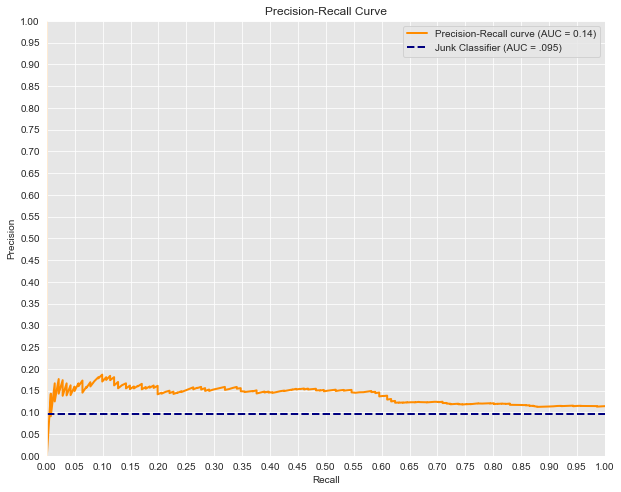

In [108]:
#chart precision recall curve for multi-variable logistic regression versus junk classifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Plot a Precision-Recall Curve
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='Precision-Recall curve (AUC = 0.14)')
plt.plot([0, 1], [0.0951, .0951], color='navy', lw=lw, linestyle='--',label='Junk Classifier (AUC = .095)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrices for Each Model

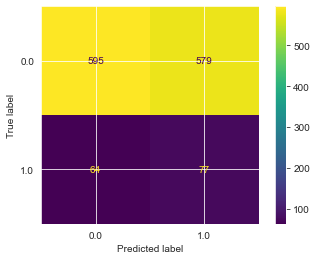

In [110]:
#plot confusion matrix for decision tree model
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(dt,X_test_encoded,y_test);

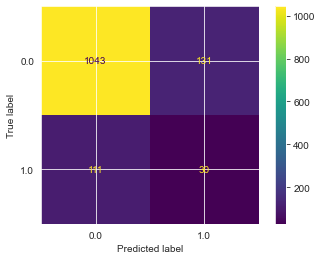

In [111]:
#import confusion matrix plot and plot confusion matrix for simple logistic regression
plot_confusion_matrix(log_model_simple,X_test_simple_scaled,y_test);

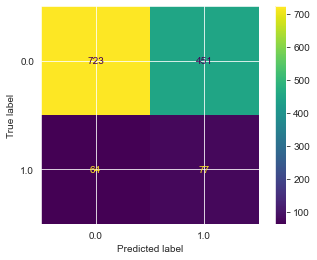

In [112]:
#plot confusion matrix for multiple X variables logistic regression
plot_confusion_matrix(log_model,X_test_scaled,y_test);

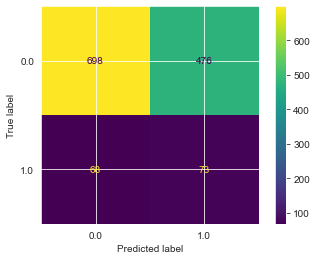

In [113]:
#plot confusion matrix for multiple X variables logistic regression (tuned)
plot_confusion_matrix(log_model_grid,X_test_scaled,y_test);

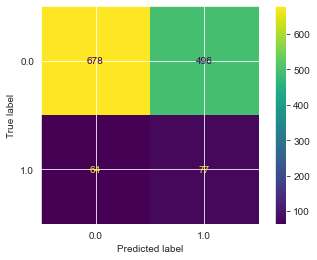

In [114]:
#plot confusion matrix for random forest model
plot_confusion_matrix(clf,X_test_encoded,y_test);

# Recommendations

From our analysis, we derived 5 key recommendations.

### The Big Issue

One of the biggest factors in severe biker injuries, the driver’s physical condition, is out of a biker’s control. In our decision tree model, this was the most important feature. An unimpaired driver reduces the likelihood of a severe injury by 30%. 

This result speaks to the continued campaigning needed against driving under the influence, which includes promoting ride share services and public transportation.

### Path for Pops

The remaining four key features have aspects that bikers can control to protect themselves. The first is age. No, bikers can’t stop time, but they may be able to cheat death. Our recommendation is to encourage elderly bikers to stick to bike paths, as they are 34% more likely to be seriously injured in an accident.

### No Need for Speed

Our second recommendation for bikers is to avoid traveling on streets with speed limits above 30 mph, as accidents that occur on these streets are 30% more likely to result in a severe injury.

### Afternoon Delight

Our third recommendation for bikers is to avoid late night and early morning travel. During these times, it’s dark, and drivers may be tired and/or impaired. Bike accidents in the early morning (classified as 1am-6am) are 22% more likely to be severe.

### Follow the Law

Our final recommendation for bikers is to obey the law. Following traffic laws and exercising caution while biking decreases the likelihood of a severe injury by 16%. Safe biker actions include traveling with traffic and crossing with the signal. Unsafe action includes traveling against traffic and crossing while not at an intersection.